# Sessió 2: Pytorch & Classificació

## **NOM**: Juan Aguilera Toro ####

## **NIU**: 1566837 ####

En aquesta sessió farem una petita introducció dels components i el procés que s'ha de realitzar al entrenar un model en **PyTorch**.

* Durant la classe, implementarem un regresor logistic binari one-vs-rest.
* A casa
 * Adaptar aquest codi per a que simuli un regressor logistic binari one-vs-one depenent del vostre **NIU**
 * Visualitzar el model
 * Aplicar regularització i veure diferencies.
 * Crear classificador multicategoria a partir de molts classificadors independents one-vs-rest.

Treballarem sobre la base de dades MNIST. Més avall teniu el codi per la seva descarrega.

### Imports

In [134]:
import argparse
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

### Parameters

En principi son parametres força estandard. No haurieu de per què tocar-los gaire si no sabeu el que volen dir.

In [135]:
batch_size = 100        # number of samples during training
test_batch_size = 1000  # number of samples for test 
epochs = 5              # number of epochs to train (default: 14)
lr = 0.01               # learning rate (default: 1.0)
gamma = 0.7             # Learning rate step gamma (default: 0.7)

no_cuda = True          # disables CUDA training
dry_run = False         # quickly check a single pass
seed = 1                # random seed (default: 1)
log_interval = 50       # how many batches to wait before logging training status
save_model = False      # For Saving the current Model


# Check if cuda is available
use_cuda = not no_cuda and torch.cuda.is_available()
print(f"USING CUDA: {use_cuda}")
torch.manual_seed(seed)

# define the device where to compute (cpu or gpu)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

USING CUDA: False


### Definició del Model

Creem un model lineal amb 784 entrades (la mida de la imatge (28x28)) i 1 sortida (Classificació binaria, és o no és)

In [136]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.w = torch.nn.Linear(784, 1)      # creem un model amb 784 entrades i 1 sortida

    def forward(self, x):                    # x:  bsx28x28
        x = torch.flatten(x, 1)              # flatten converteix una matriu en un array  x-> 28x28 -> 784x1
        x = self.w(x)                        # aplica els pesos sum(w*x) ->  784x1 -> 1
        x = torch.sigmoid(x)            # aplica la sigmoid  <- SVM la fa servir??
        return torch.flatten(x, 0)      # return bs probs


### Definició de la Loss

In [137]:
class LogisticLoss(torch.nn.modules.Module):
    def __init__(self):
        super(LogisticLoss, self).__init__()

    def forward(self, outputs, labels):
        batch_size = outputs.size()[0]
        outputs = (outputs * 2) - 1
        labels = (labels * 2) - 1  # labels -> 1 or -1
        return torch.sum(torch.log(1 + torch.exp(-(outputs.t() * labels)))) / batch_size

class HingeLoss(torch.nn.modules.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, outputs, labels):
        batch_size = outputs.size()[0]
        outputs = (outputs * 2) - 1
        labels = (labels * 2) - 1   # labels -> 1 or -1
        return torch.sum(torch.clamp(1 - outputs.t() * labels, min=0)) / batch_size # modificar el 1 per la loss corresponent


Recordeu la formula de la hinge loss: $ \frac{1}{n}\sum max(0, 1 - t * y) $

### Funcions auxiliars

In [138]:
def visualize_model(model):
    # Apartat B. Mostrar pesos del model
    plt.figure(0)
    #extraiem els pesos del model i els reformatajem en format imatge.
    plt.imshow(model.w.weight.detach().numpy().reshape(28, 28), interpolation='nearest', cmap=plt.cm.RdBu)
    plt.show()
    
def visualize_confusion_matrix(y_pred, y_real):
    #mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def convert_dataset_to_binary_one_vs_one(dataset, positive_class = 7, negative_class = 3):
    # NIU: 1566837 -> 7 pos, 3 neg
    # One-vs-One
    # TODO. Apartat A. Aqui pots fer servir la funcio subset per tal reduir el nombre d'exemples
    # funcions que podeu fer servir:
    # torch.nonzero(X, as_tuple=True)[0]
    # torch.logical_or(X1,X2)
    # dataset = torch.utils.data.Subset(dataset, index_of_interest)

    dataset.targets[dataset.targets == negative_class] = -1.0
    dataset.targets[dataset.targets == positive_class] = 1.0
    dataset.targets[dataset.targets == -1.0] = 0.0

    print(f"SIZE of dataset {len(dataset)}")
    return dataset
    

def convert_dataset_to_binary_one_vs_rest(dataset, positive_class):
    # One-vs-Rest    
    dataset.targets[dataset.targets != positive_class] = -1.0
    dataset.targets[dataset.targets == positive_class] = 1.0
    dataset.targets[dataset.targets == -1.0] = 0.0
        
    print(f"SIZE of dataset {len(dataset)}")
    return dataset

### Train loop (1 epoca)

In [139]:
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval):
    #Ens posem en mode entrenament.
    model.train()
    #iterem les dades en batches (o lots)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # en el cas de treballar en cuda o gpu, ara els hi posariem
        optimizer.zero_grad()  # posem el gradient a zero (important) ja que sino, s'aniria acumulant a cada iteració
        output = model(data)   # fem un predict del model amb les dades actuals
        loss = criterion(output.view_as(target), target.type_as(output))  # calculem el error obtingut
        loss.backward()             # li diem que calculi el gradient
        optimizer.step()            # actualitza els pesos amb el gradient calculat
        if batch_idx % log_interval == 0:  # cada log_interval loops mostrem informació
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            visualize_model(model)


# Resultat apartat B:

Descomentem la funció visualize_model per poder observar graficament la variabilitat de w al llarg de l'entrenament del model.

### Test Loop

In [140]:
def test(model, device, test_loader, criterion, show_confusion_matrix=False):
    model.eval()     # ens posem en mode evaluació
    test_loss = 0    # variables per acumular resultats
    correct = 0
    all_preds = [] 
    all_outputs = [] 
    all_targets = []
    with torch.no_grad():  # li estem dient que estem en evaluacio, i que necesitem calcular el gradient aqui dins 
        for data, target in test_loader:   # per cada batch de test
            data, target = data.to(device), target.to(device)  # posar-ho a la cpu o a la gpu
            output = model(data)    # fer la prediccio
            test_loss += criterion(output.view_as(target), target.type_as(output)).item() * data.shape[0]  # acumulem error
            pred = (output > 0.5) * 1  # per comprobar la prediccio escollim el threshold a 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred)
            all_targets.extend(target)
            all_outputs.extend(output)

    test_loss /= len(test_loader.dataset) # fem la mitja de l'error del dataset
    if show_confusion_matrix:
        visualize_confusion_matrix(all_targets, all_preds)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return all_outputs

### Preparar les dades d'entrenament

In [141]:
# Definim un pipeline que se li aplicarà a les dades del dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Aqui agafem les dades del propi torch. Si no les tenim, amb el parametre download ens el baixarem automaticament.
# Esculliu on voleu descarregar-vos les dades i intenteu de no anar-les replicant per totes les carpetes..
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, transform=transform)

# TODO. Apartat A. Aqui convertim el dataset en binari one-vs-rest.
#  Modifiqueu la funcio per adaptar el vostre niu
# convert multiclass dataset into binary classes
#dataset1 = convert_dataset_to_binary_one_vs_rest(dataset1, 0)
#dataset2 = convert_dataset_to_binary_one_vs_rest(dataset2, 0)

dataset1 = convert_dataset_to_binary_one_vs_one(dataset1, 7, 3)
dataset2 = convert_dataset_to_binary_one_vs_one(dataset2, 7, 3)

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)



SIZE of dataset 60000
SIZE of dataset 10000


### Instanciació i entrenament

# Resultat apartat C:


Default weight_decay es 0, pero el modificarem.

Veiem que si utilitzem un weight decay de 0 al crear l'optimizer obtenim una accuracy de 28.26%

w_d = 0.01 -> 28.02%

w_d = 0.1 -> 25.69%

w_d = 0.5 -> 22.42%

w_d = 1.0 -> 21.66%

w_d = 2.0 -> 21.63%

w_d = 10 -> 21.63%

Un cop hem trastejat amb el weight decay podem veure varies coses. La primera i la més clara, i la que esperavem que succeix, es que en valors propers i superiors a la unitat, obtenim un valor de accuracy molt baix.

La cosa es que també podem veure que ha succeït quan hem modificat valors com se'ns recomana a la pagina web que ens doneu per llegir al respecte del weight decay, i ens pot sorprendre veure que per molt que modifiquessim valors com 0.1 o 0.01 seguim obtenint valors pitjors que la accuracy inicial amb el weight decay igual a zero.

LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.543988


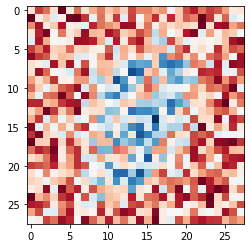

Train Epoch: 1 [5000/60000 (8%)]	Loss: -242.361557


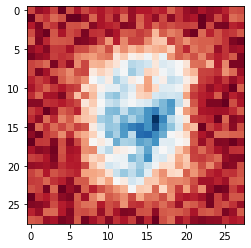

Train Epoch: 1 [10000/60000 (17%)]	Loss: -250.157700


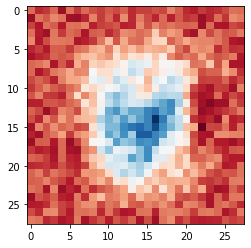

Train Epoch: 1 [15000/60000 (25%)]	Loss: -196.209167


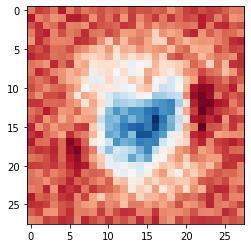

Train Epoch: 1 [20000/60000 (33%)]	Loss: -256.707092


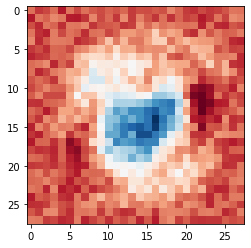

Train Epoch: 1 [25000/60000 (42%)]	Loss: -222.829819


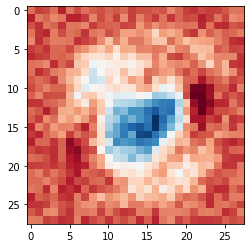

Train Epoch: 1 [30000/60000 (50%)]	Loss: -245.581192


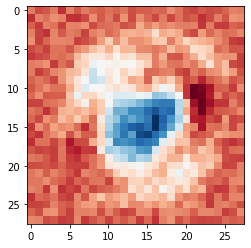

Train Epoch: 1 [35000/60000 (58%)]	Loss: -306.886475


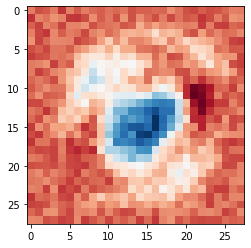

Train Epoch: 1 [40000/60000 (67%)]	Loss: -228.333939


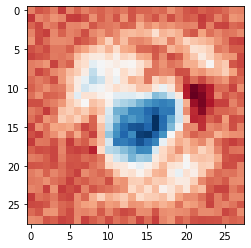

Train Epoch: 1 [45000/60000 (75%)]	Loss: -245.189056


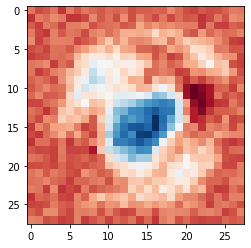

Train Epoch: 1 [50000/60000 (83%)]	Loss: -301.452454


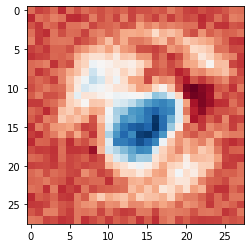

Train Epoch: 1 [55000/60000 (92%)]	Loss: -228.222214


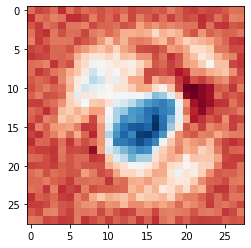

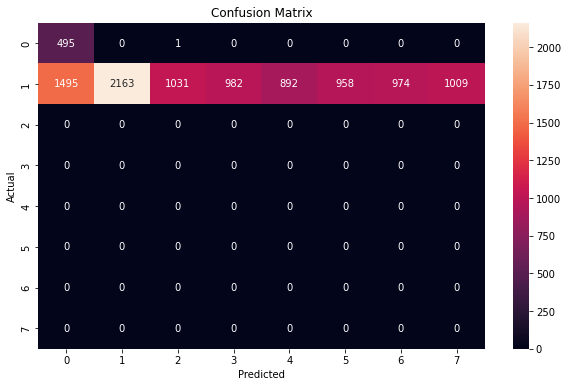


Test set: Average loss: -257.0631, Accuracy: 2658/10000 (26.58%)

LEARNING RATE USED: [0.006999999999999999]
Train Epoch: 2 [0/60000 (0%)]	Loss: -239.764740


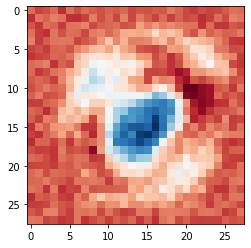

Train Epoch: 2 [5000/60000 (8%)]	Loss: -258.067474


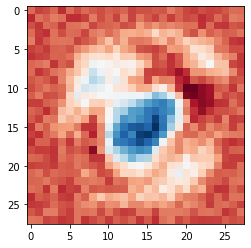

Train Epoch: 2 [10000/60000 (17%)]	Loss: -261.225616


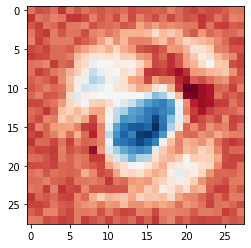

Train Epoch: 2 [15000/60000 (25%)]	Loss: -212.271072


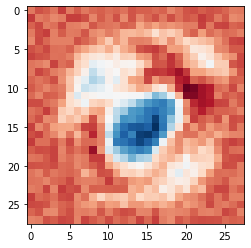

Train Epoch: 2 [20000/60000 (33%)]	Loss: -256.997589


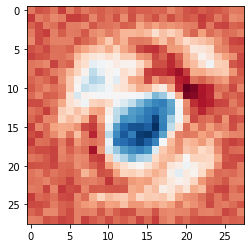

Train Epoch: 2 [25000/60000 (42%)]	Loss: -229.909225


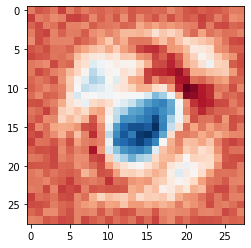

Train Epoch: 2 [30000/60000 (50%)]	Loss: -244.825073


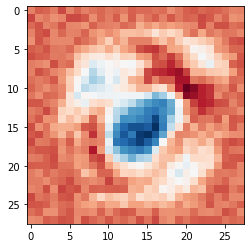

Train Epoch: 2 [35000/60000 (58%)]	Loss: -313.638428


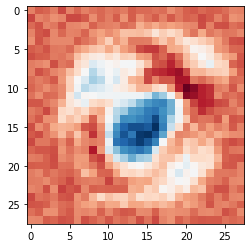

Train Epoch: 2 [40000/60000 (67%)]	Loss: -233.691193


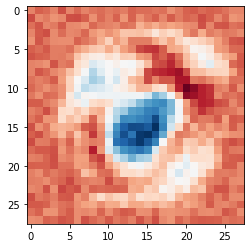

Train Epoch: 2 [45000/60000 (75%)]	Loss: -242.798782


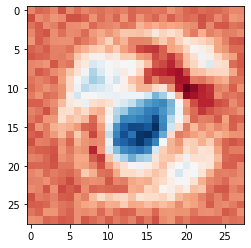

Train Epoch: 2 [50000/60000 (83%)]	Loss: -302.378693


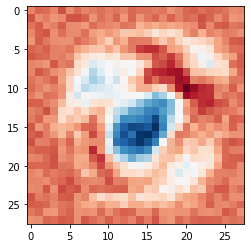

Train Epoch: 2 [55000/60000 (92%)]	Loss: -229.840073


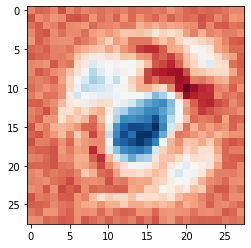

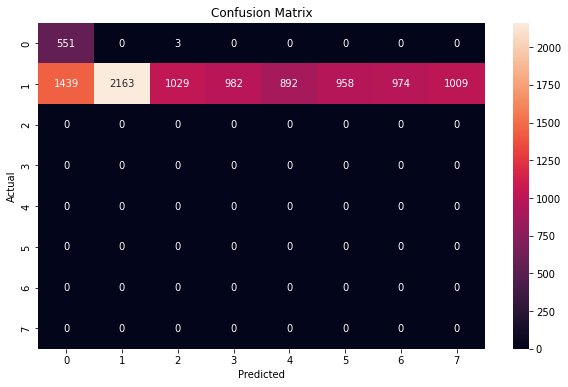


Test set: Average loss: -258.7604, Accuracy: 2714/10000 (27.14%)

LEARNING RATE USED: [0.004899999999999999]
Train Epoch: 3 [0/60000 (0%)]	Loss: -241.420181


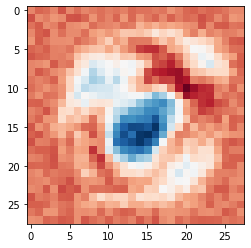

Train Epoch: 3 [5000/60000 (8%)]	Loss: -258.831299


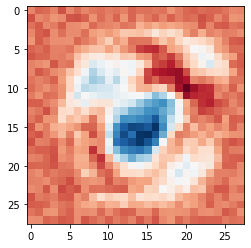

Train Epoch: 3 [10000/60000 (17%)]	Loss: -263.145264


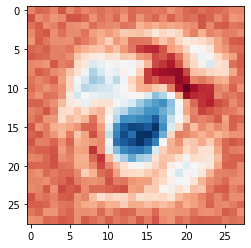

Train Epoch: 3 [15000/60000 (25%)]	Loss: -215.940094


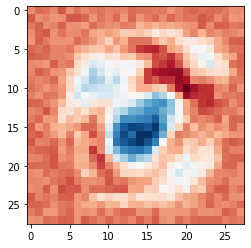

Train Epoch: 3 [20000/60000 (33%)]	Loss: -256.151886


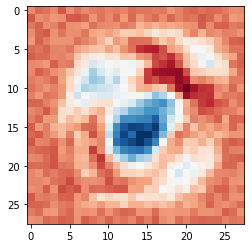

Train Epoch: 3 [25000/60000 (42%)]	Loss: -229.901382


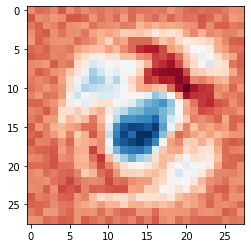

Train Epoch: 3 [30000/60000 (50%)]	Loss: -245.633362


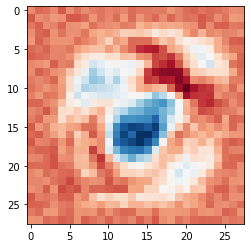

Train Epoch: 3 [35000/60000 (58%)]	Loss: -316.202881


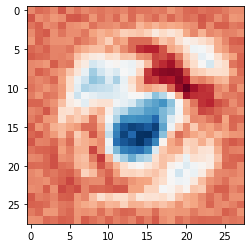

Train Epoch: 3 [40000/60000 (67%)]	Loss: -232.963913


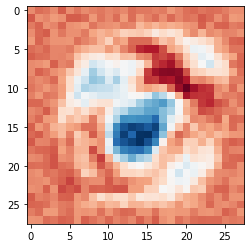

Train Epoch: 3 [45000/60000 (75%)]	Loss: -244.616058


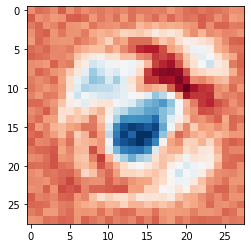

Train Epoch: 3 [50000/60000 (83%)]	Loss: -296.455231


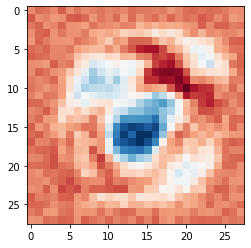

Train Epoch: 3 [55000/60000 (92%)]	Loss: -230.714844


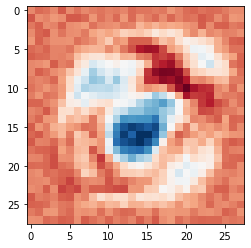

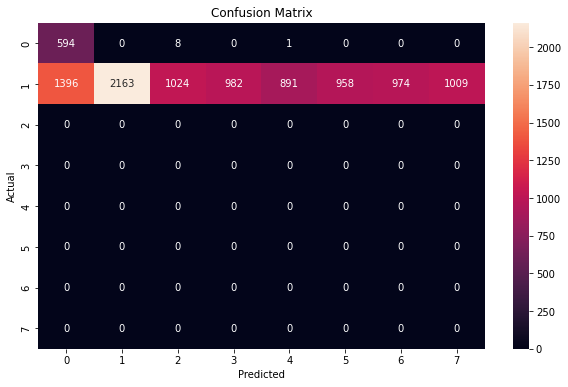


Test set: Average loss: -258.7711, Accuracy: 2757/10000 (27.57%)

LEARNING RATE USED: [0.003429999999999999]
Train Epoch: 4 [0/60000 (0%)]	Loss: -242.344284


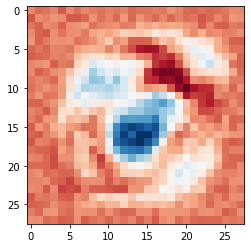

Train Epoch: 4 [5000/60000 (8%)]	Loss: -262.345642


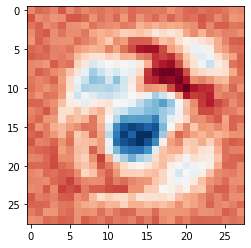

Train Epoch: 4 [10000/60000 (17%)]	Loss: -266.962097


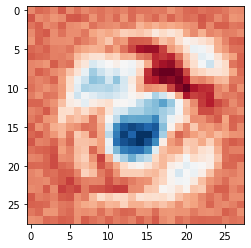

Train Epoch: 4 [15000/60000 (25%)]	Loss: -223.946487


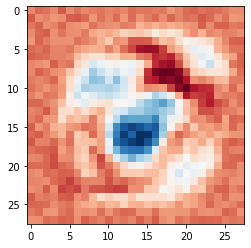

Train Epoch: 4 [20000/60000 (33%)]	Loss: -250.222931


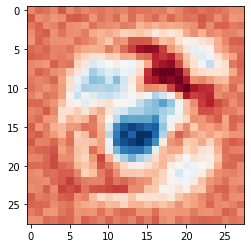

Train Epoch: 4 [25000/60000 (42%)]	Loss: -231.615982


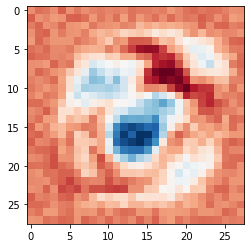

Train Epoch: 4 [30000/60000 (50%)]	Loss: -243.932007


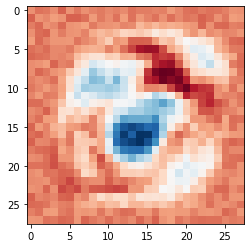

Train Epoch: 4 [35000/60000 (58%)]	Loss: -318.101562


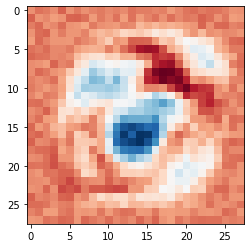

Train Epoch: 4 [40000/60000 (67%)]	Loss: -234.773987


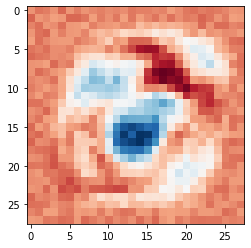

Train Epoch: 4 [45000/60000 (75%)]	Loss: -249.830170


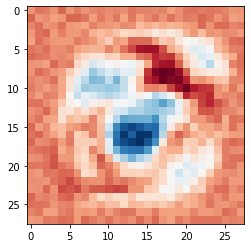

Train Epoch: 4 [50000/60000 (83%)]	Loss: -297.175507


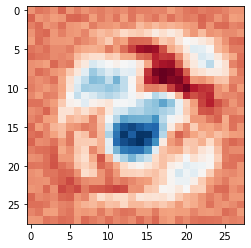

Train Epoch: 4 [55000/60000 (92%)]	Loss: -231.618210


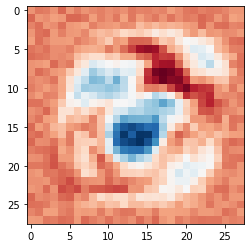

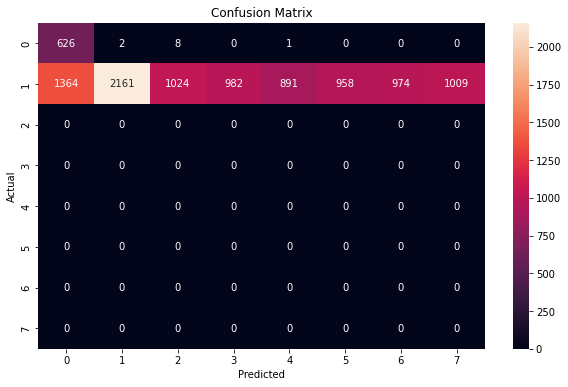


Test set: Average loss: -259.2515, Accuracy: 2787/10000 (27.87%)

LEARNING RATE USED: [0.002400999999999999]
Train Epoch: 5 [0/60000 (0%)]	Loss: -243.414398


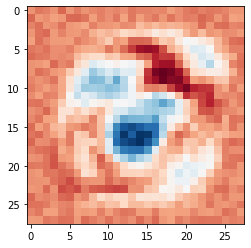

Train Epoch: 5 [5000/60000 (8%)]	Loss: -262.517395


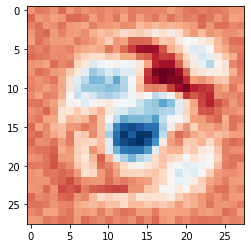

Train Epoch: 5 [10000/60000 (17%)]	Loss: -268.139038


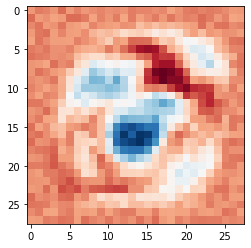

Train Epoch: 5 [15000/60000 (25%)]	Loss: -220.111099


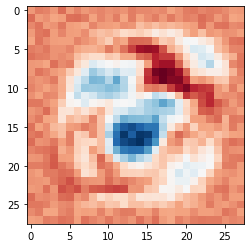

Train Epoch: 5 [20000/60000 (33%)]	Loss: -253.559097


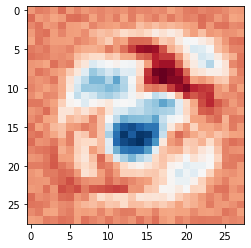

Train Epoch: 5 [25000/60000 (42%)]	Loss: -232.574524


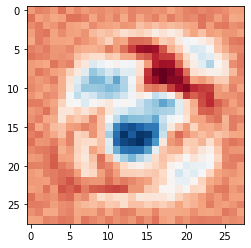

Train Epoch: 5 [30000/60000 (50%)]	Loss: -246.468216


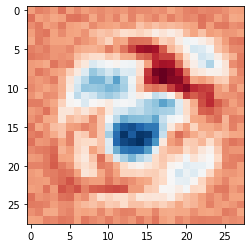

Train Epoch: 5 [35000/60000 (58%)]	Loss: -313.218170


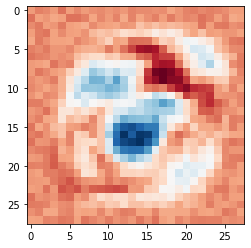

Train Epoch: 5 [40000/60000 (67%)]	Loss: -234.848007


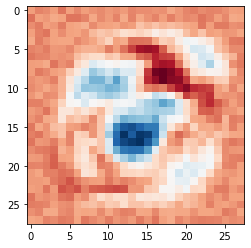

Train Epoch: 5 [45000/60000 (75%)]	Loss: -251.617935


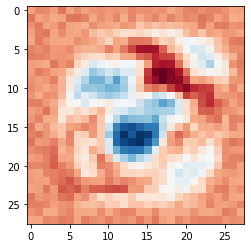

Train Epoch: 5 [50000/60000 (83%)]	Loss: -297.141479


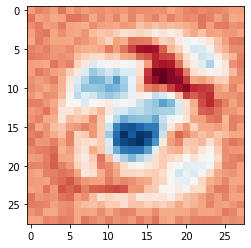

Train Epoch: 5 [55000/60000 (92%)]	Loss: -232.557968


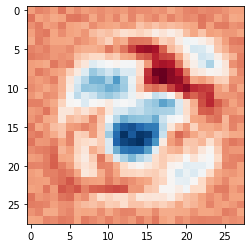

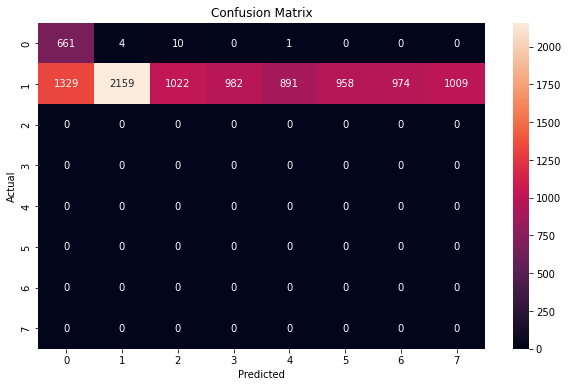


Test set: Average loss: -258.8605, Accuracy: 2820/10000 (28.20%)



In [142]:
model = Model().to(device)  # instanciació del model
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)   # optimitzador (Apartat C. Aqui podem definir el weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # permet reduir el Learning rate

# criterion = LogisticLoss()
# criterion = HingeLoss()
criterion = torch.nn.BCELoss(reduction='mean')

for epoch in range(1, epochs + 1):
    # A cada epoca, fem un entrenament del model (es veu un cop cada exemple)
    print("LEARNING RATE USED: {}".format(scheduler.get_last_lr()))
    train(model, device, train_loader, optimizer, criterion, epoch, log_interval)
    o = test(model, device, test_loader, criterion, True)
    scheduler.step()  # reduim el Learning Rate segons el scheduler StepLR que fa servir gamma

if save_model:
    torch.save(model.state_dict(), "mnist.pt")


# Resultat apartat A:

Obtenim un accuracy de 2826/10000, el que es 28.26%

I podem apreciar les matrius de confusió de cada época.

### Multiples models

CATEGORIA 0
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.725213


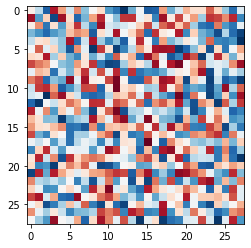

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.105607


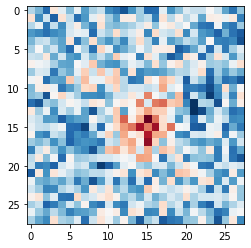

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.070065


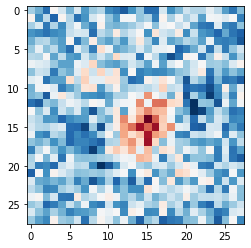

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.058306


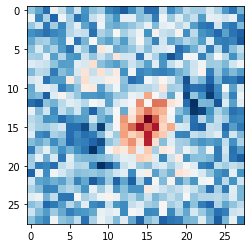

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.061085


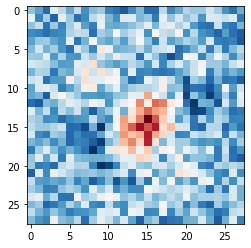

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.088732


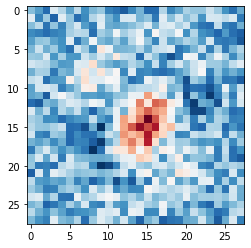

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.057372


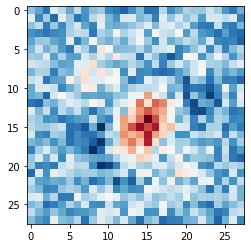

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.055989


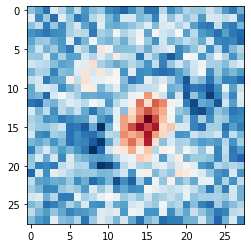

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.030826


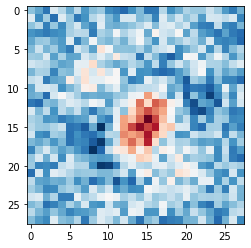

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.031483


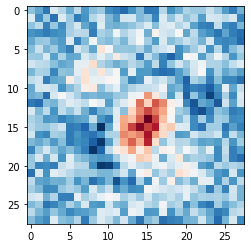

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.027295


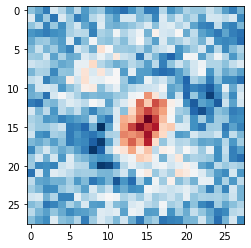

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.015432


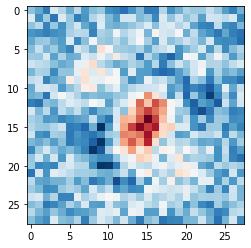


Test set: Average loss: 0.0389, Accuracy: 9884/10000 (98.84%)

CATEGORIA 1
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.717962


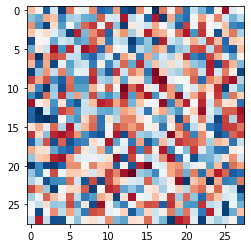

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.078453


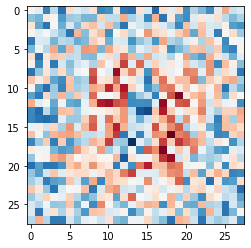

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.075063


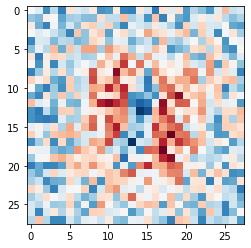

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.070143


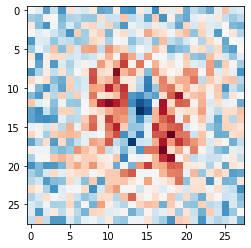

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.117186


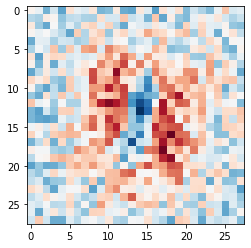

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.059288


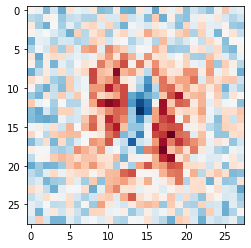

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.058806


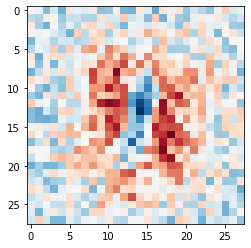

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.030824


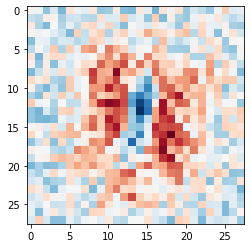

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.042607


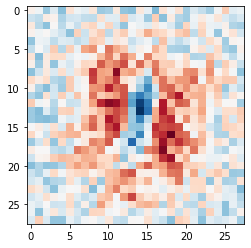

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.042132


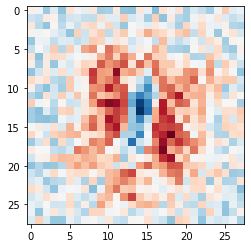

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.048335


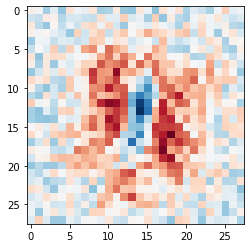

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.031842


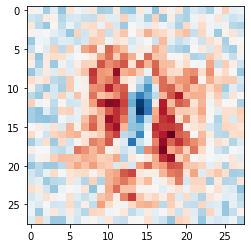


Test set: Average loss: 0.0407, Accuracy: 9884/10000 (98.84%)

CATEGORIA 2
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.518137


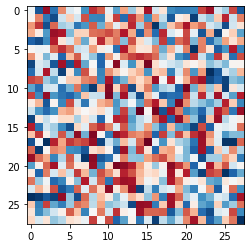

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.126782


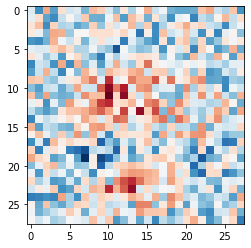

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.114354


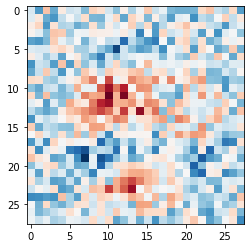

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.114615


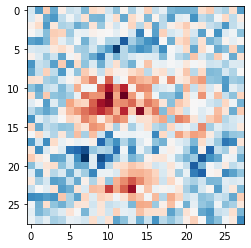

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.101166


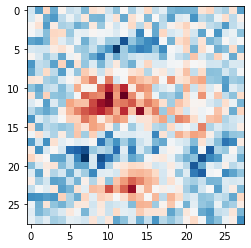

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.068068


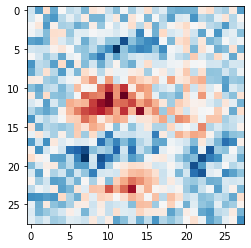

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.113287


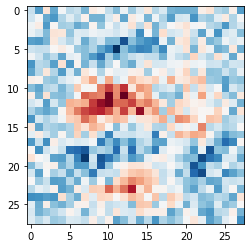

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.061384


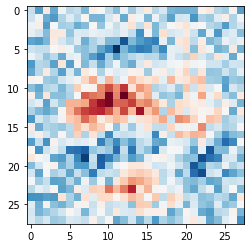

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.095060


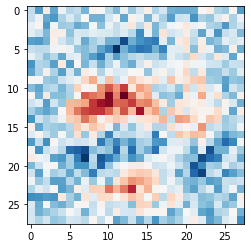

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.258643


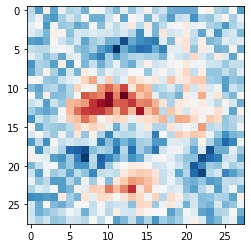

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.096193


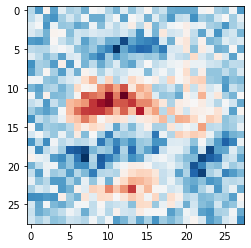

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.118966


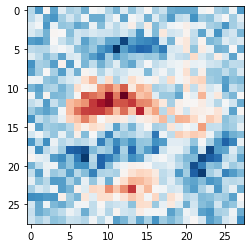


Test set: Average loss: 0.0910, Accuracy: 9715/10000 (97.15%)

CATEGORIA 3
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.745209


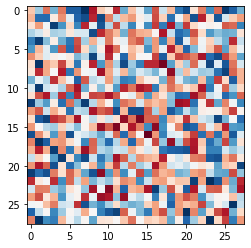

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.165482


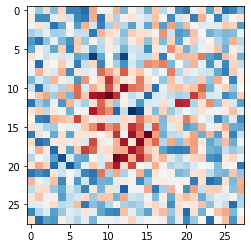

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.090002


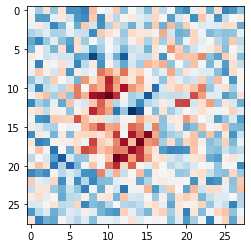

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.122319


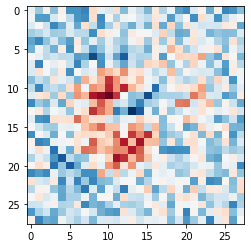

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.176829


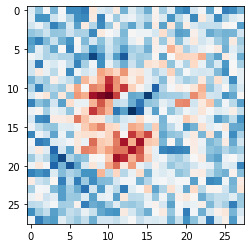

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.119090


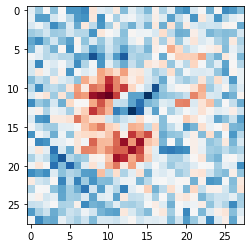

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.203416


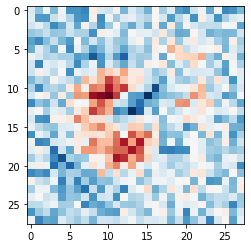

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.089626


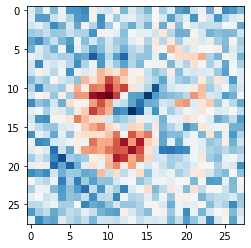

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.107987


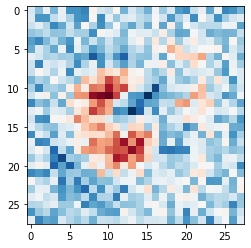

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.148339


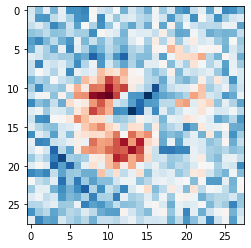

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.135483


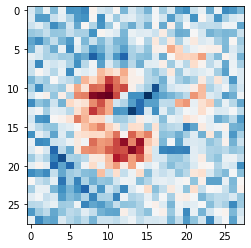

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.074015


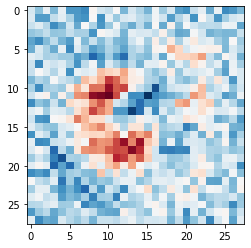


Test set: Average loss: 0.0900, Accuracy: 9729/10000 (97.29%)

CATEGORIA 4
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.642017


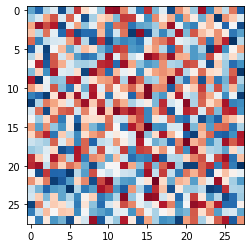

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.162796


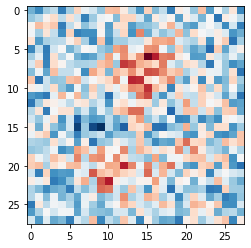

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.076729


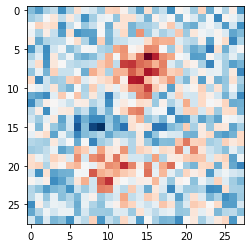

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.072769


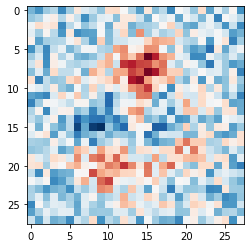

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.112206


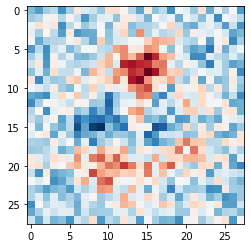

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.074600


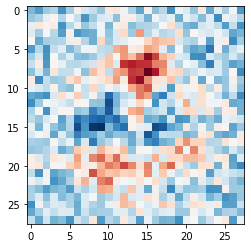

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.107918


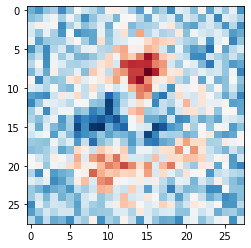

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.045972


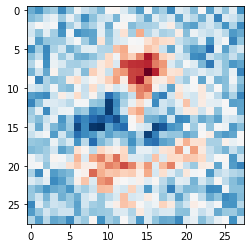

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.052958


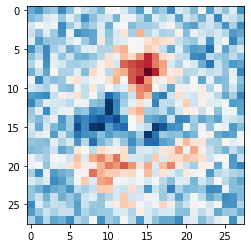

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.147666


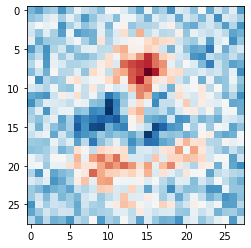

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.123292


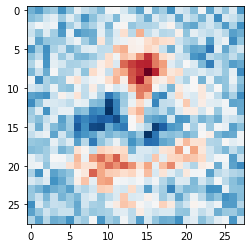

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.047899


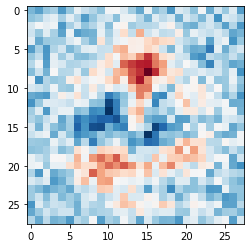


Test set: Average loss: 0.0799, Accuracy: 9736/10000 (97.36%)

CATEGORIA 5
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.466734


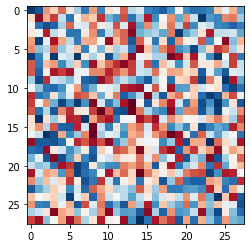

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.213069


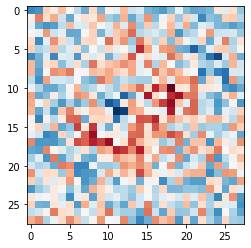

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.136640


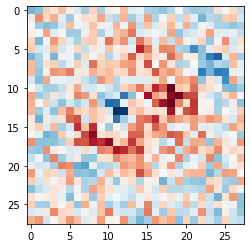

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.137587


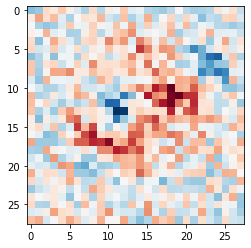

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.132990


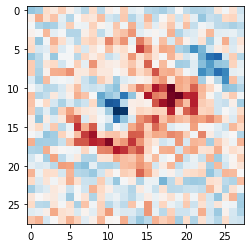

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.137717


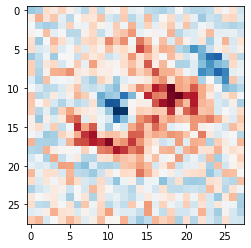

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.106761


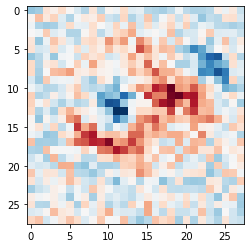

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.103336


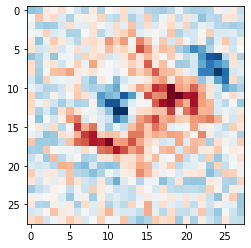

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.123249


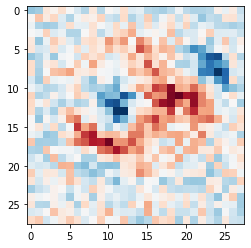

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.135676


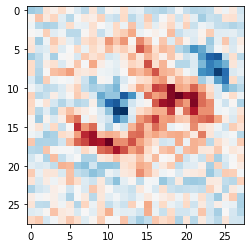

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.119792


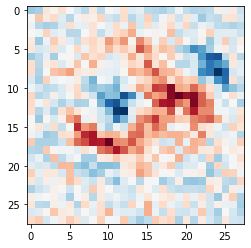

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.148888


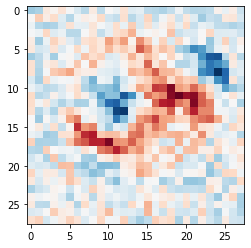


Test set: Average loss: 0.1153, Accuracy: 9625/10000 (96.25%)

CATEGORIA 6
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.676135


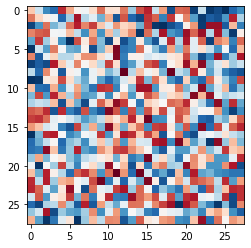

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.123645


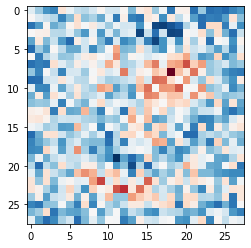

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.117009


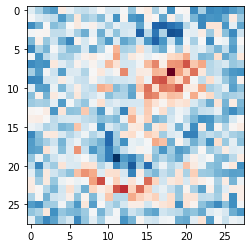

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.062895


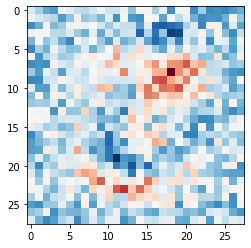

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.037182


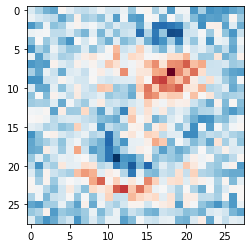

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.050445


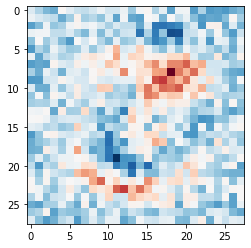

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.076629


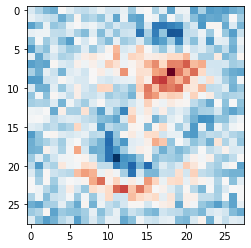

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.052243


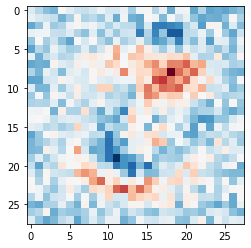

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.053307


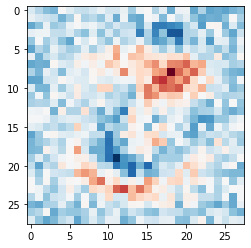

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.043054


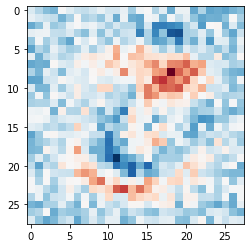

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.040549


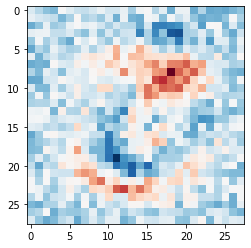

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.064545


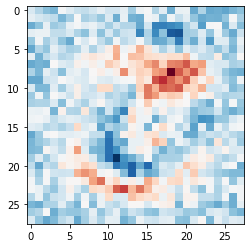


Test set: Average loss: 0.0562, Accuracy: 9820/10000 (98.20%)

CATEGORIA 7
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.744209


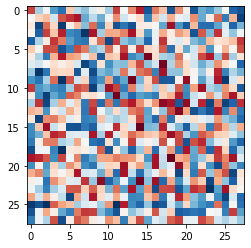

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.125369


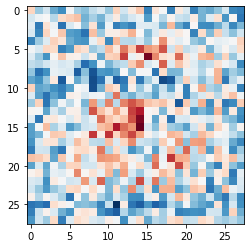

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.099132


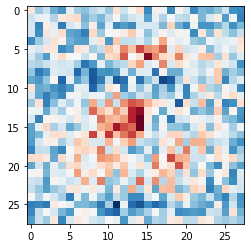

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.056017


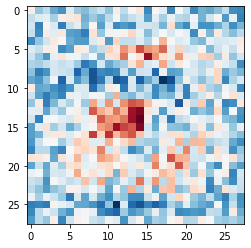

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.110817


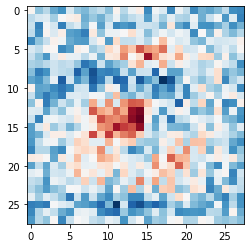

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.047807


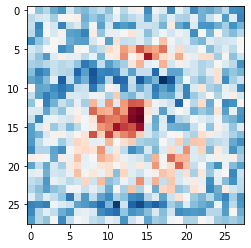

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.052086


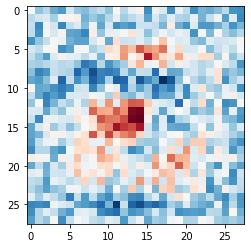

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.035516


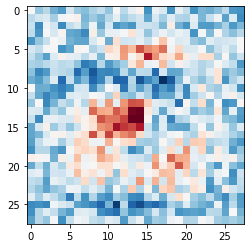

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.058307


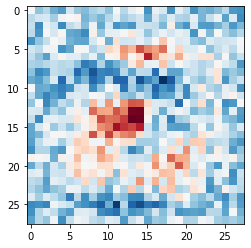

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.050728


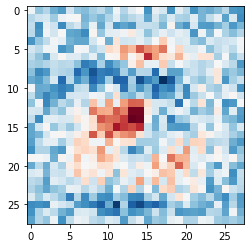

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.062342


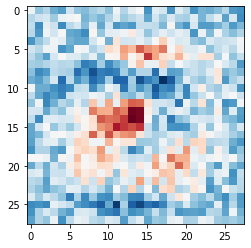

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.087696


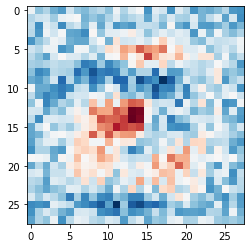


Test set: Average loss: 0.0683, Accuracy: 9801/10000 (98.01%)

CATEGORIA 8
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.763021


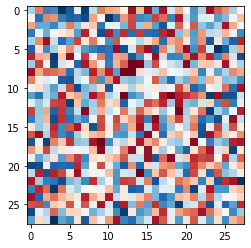

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.214077


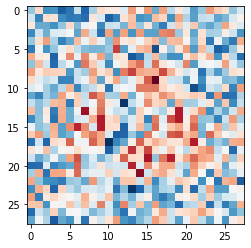

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.225996


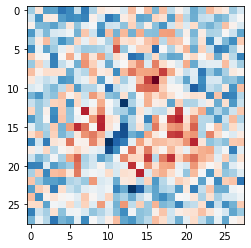

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.112775


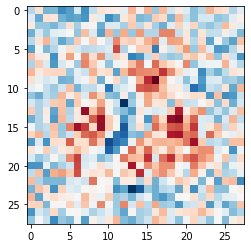

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.268679


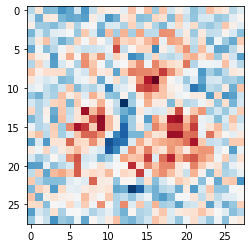

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.165724


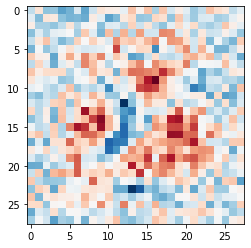

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.117999


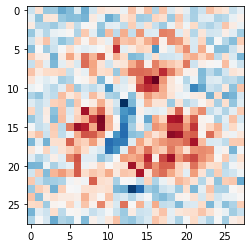

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.157668


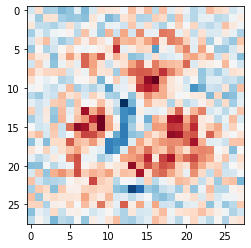

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.190403


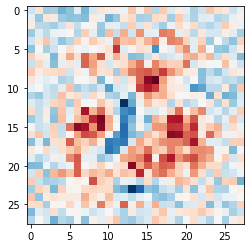

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.167249


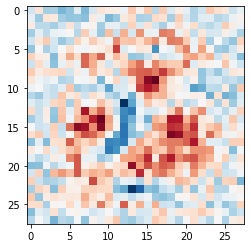

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.129828


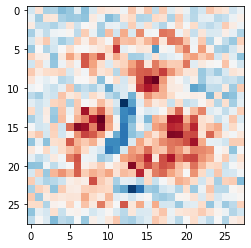

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.107252


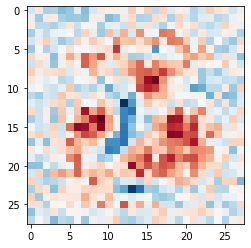


Test set: Average loss: 0.1276, Accuracy: 9564/10000 (95.64%)

CATEGORIA 9
SIZE of dataset 60000
SIZE of dataset 10000
LEARNING RATE USED: [0.01]
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.929749


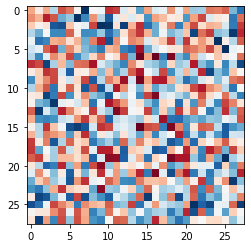

Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.234144


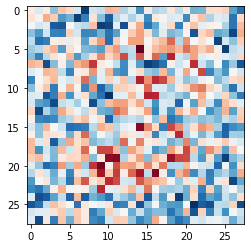

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.198442


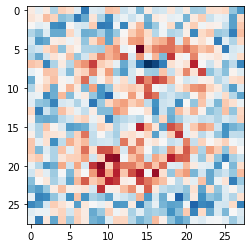

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.146578


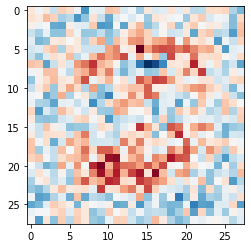

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.169391


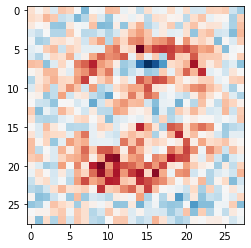

Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.098619


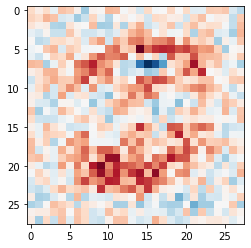

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.199208


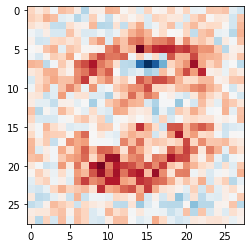

Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.125256


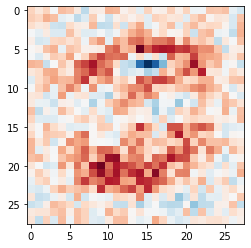

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.104675


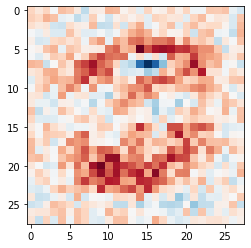

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.120107


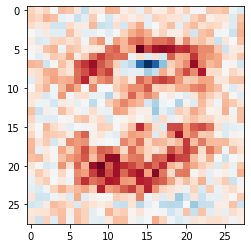

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.178907


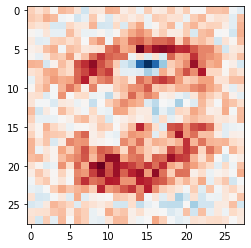

Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.109647


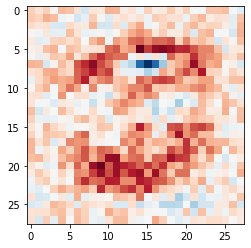


Test set: Average loss: 0.1232, Accuracy: 9604/10000 (96.04%)



In [143]:
#Apartat D
epochs = 1  # per anar més rapid... només fem una epoca per número..

output = np.zeros((10000, 10)) # matriu on guardarem els resultats (10000 samples x 10 categories)

for i_categoria in range(10):
    print(f"CATEGORIA {i_categoria}")
    # agafem tot el dataset
    dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, transform=transform)

    # seleccionem i modifiquem els labels per convertir el dataset a classificació binaria
    dataset1 = convert_dataset_to_binary_one_vs_rest(dataset1, i_categoria)
    dataset2 = convert_dataset_to_binary_one_vs_rest(dataset2, i_categoria)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Model().to(device)  # instanciar el model
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # instanciar el optimitzador
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

    criterion = torch.nn.BCELoss(reduction='mean')  # definir la loss

    for epoch in range(1, epochs + 1):
        # A cada epoca, fem un entrenament del model (es veu un cop cada exemple)
        print("LEARNING RATE USED: {}".format(scheduler.get_last_lr()))
        train(model, device, train_loader, optimizer, criterion, epoch, log_interval)
        if epoch==epochs:  # a la ultima iteració del training, fem la predicció
            i_output = test(model, device, test_loader, criterion, show_confusion_matrix=False)
            output[:, i_categoria] = np.asarray(i_output)
            
        scheduler.step()  # reduim el Learning Rate segons el scheduler StepLR que fa servir gamma
    
    if save_model:
        torch.save(model.state_dict(), f"mnist_{i_categoria}.pt")


# Resultat apartat D:

0 -> Test set: Average loss: 0.0389, Accuracy: 9884/10000 (98.84%)

1 -> Test set: Average loss: 0.0407, Accuracy: 9884/10000 (98.84%)

2 -> Test set: Average loss: 0.0910, Accuracy: 9715/10000 (97.15%)

3 -> Test set: Average loss: 0.0900, Accuracy: 9729/10000 (97.29%)

4 -> Test set: Average loss: 0.0799, Accuracy: 9736/10000 (97.36%)

5 -> Test set: Average loss: 0.1153, Accuracy: 9625/10000 (96.25%)

6 -> Test set: Average loss: 0.0562, Accuracy: 9820/10000 (98.20%)

7 -> Test set: Average loss: 0.0683, Accuracy: 9801/10000 (98.01%)

8 -> Test set: Average loss: 0.1276, Accuracy: 9564/10000 (95.64%)

9 -> Test set: Average loss: 0.1232, Accuracy: 9604/10000 (96.04%)

Aqui podem veure els resultats obtinguts tras fer el tractament dels 10 valors

In [144]:
# Apartat D
# a output, tenim totes les prediccions, per cada sample, la predicció de cada categoria. hem de quedar-nos amb la categoria més probable
# agafem els labels originals de test
# visualitzar matriu de confusio (per extreurels de dataset: dataset2.targets.numpy())
# calcular el accuracy final multicategoria
multiclass_accuracy = 0
print(f"FINAL ACCURACY: {multiclass_accuracy}")

FINAL ACCURACY: 0


## Entrega

* A. Seleccioneu les categories segons el vostre NIU. Feu One-VS-One. Fer un entrenament i mostrar l'accuracy i la matriu de confusió. **(3pts)**

* B. Visualitzar i comentar els pesos w en format imatge. Fer servir la funcion visualize_model(model). Potser a diferents punts del entrenament? **(3pts)**

* C. Què passa si regularitzeu els pesos. Podrieu sumarli el cost a la loss, o bé, utilitzar el ``weight_decay`` en el Optimitzador, que aplica un L2 penalty. Proveu varis valors. [Explicació](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab) **(2pts)**

* D. Fer 10 classificadors. Cada un one-vs-rest. (ie. 0vsRest, 1vsRest..). Aplicar els 10 models al test. Agafar la categoria més probable de les 10 i mostrar la matriu de confusió resultant. Quin accuracy aconseguiu? **(2pts)**


Les respostes o tractaments de codi es troben al llarg del document jupyter notebook sota la indexació d'un '#' al format markdown, i acompanyades pel text Resultat apartat X: